# Demonstration of RED optimzation for Phase Retrieval
following the work from prDeep and showing how to use fasta-python. The original fasta-python implementation is [here](https://github.com/phasepack/fasta-python/tree/master/fasta) but it may no longer be being maintained so I forked it [here](https://github.com/ianhi/fasta-python/tree/master/fasta) and will work to make the examples function again.

Here I use the skimage total variation denoising filter to do phase retrieval on the camera image.

Currently I initialize with a noisy version of the original image, a clear next step is to initalize with CHIO.

In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt

from fasta import fasta, plots, Convergence
# from fasta.examples import ExampleProblem, test_modes
from fasta.linalg import LinearMap
from skimage import data as sk_data
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle
from skimage.util import random_noise
import skimage.transform as transforms

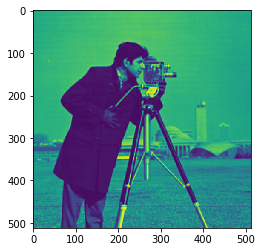

In [2]:
plt.imshow(sk_data.camera())
cam_mags = np.abs(np.fft.fft2(sk_data.camera()))

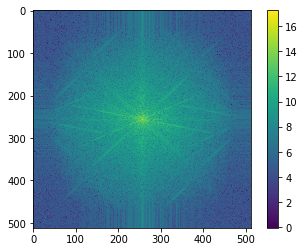

In [3]:
plt.imshow(np.log(np.abs(np.fft.fftshift(cam_mags))))
plt.colorbar()

# Creating functions for optimization
Remember Fasta minimizes functions of the form $f(Ax)+g(x)$ and we are constructing this with:  
$f(Ax) = \left||Abs(Ax)-\text{measured_mags}|\right|^2$  
where A performs the fourier transform, and the bars represent the frobenius norm. So A and At can be either matrices or functions that perform the approriate operations. 

I try to keep everything in the same shape as the image except for g(x) which computes $x^T\cdot(x-denoise(x))$ as a scalar and so x needs to be unraveled there. 

To change things you need to modify the functions

In [4]:
# Optimization parameters
lamb = .1
proximal_iters=2
image_shape = sk_data.camera().shape
# defining the functions for the problem
def A(x):
    """
    linear operator A in f(Ax) + g(x)
    params
    -----
    x : np.ndarray, dtype = real
        Takes in the real image. 
    you may need to do reshaping here if oversampling
    """
    return np.fft.fft2(x)
def At(x):
    """
    Adjoint/transpose of the linear operator A in f(Ax) + g(x)
    params
    -----
    x : np.ndarray, dtype = complex
        Takes in fourier magnitudes. 
    need to do reshaping here if oversampling
    """
    return np.real(np.fft.ifft2(x))
def denoi(x):
    """
    Apply the denoising(real space modification) function to the real space image
    
    params
    -----
    x : np.ndarray, dtype = real
        
    """
    return denoise_tv_chambolle(np.real(x))
def f(Z):
    out = .5 * la.norm((np.abs(Z) - cam_mags),ord='fro')**2 
    return out
def sub_grad_f(Z):
    """
    Subgradient function as in prDeep paper.
    params
    -----
    Z : 
    """
    out = Z-cam_mags*Z/abs(Z)
    return out
def g(z):
    """
    This function is only used if evaluate_object = True, it is not necessary for the optimization
    """
    x = z.ravel()
    return .5*lamb*x.T @ (x-denoi(x))


def proxg(Z, t):
    x = np.real(Z)
    for i in range(proximal_iters):
        x = (1/(1+t*lamb))*(Z+t*lamb*denoi(x))
    return x



# Create the linear map object that holds A and At
Linear_map = LinearMap(A,At, Vshape=image_shape,Wshape=image_shape)



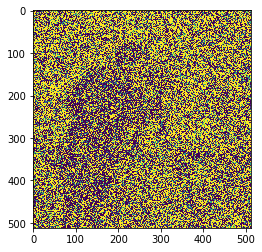

Initializing FASTA...

Iteration #	Residual	Stepsize	Accel. param	Backtracks	Objective
[0     ]	6.814022e+04	2.899187e-03	1.000000e+00	     0	0.000000e+00
[1     ]	6.794237e+04	9.999998e-01	1.618034e+00	     0	0.000000e+00
Restarted acceleration.
[2     ]	1.914298e+04	7.801813e-01	1.000000e+00	     0	0.000000e+00
[3     ]	4.207985e+03	1.000000e+00	1.618034e+00	     0	0.000000e+00
Restarted acceleration.
[4     ]	1.185615e+03	7.801812e-01	1.000000e+00	     0	0.000000e+00
[5     ]	2.606310e+02	1.000000e+00	1.618034e+00	     0	0.000000e+00
Restarted acceleration.
[6     ]	7.346648e+01	7.801811e-01	1.000000e+00	     0	0.000000e+00
[7     ]	1.629306e+01	9.999988e-01	1.618034e+00	     0	0.000000e+00
[8     ]	5.063546e+00	7.801630e-01	2.193527e+00	     0	0.000000e+00
[9     ]	2.638906e+00	1.138667e+00	2.749791e+00	     0	0.000000e+00
[10    ]	2.317313e+00	2.064407e+00	3.294880e+00	     0	0.000000e+00
[11    ]	2.518377e+00	5.189875e+00	3.832601e+00	     0	0.000000e+00
[12    ]	1.194115e+01	1.2

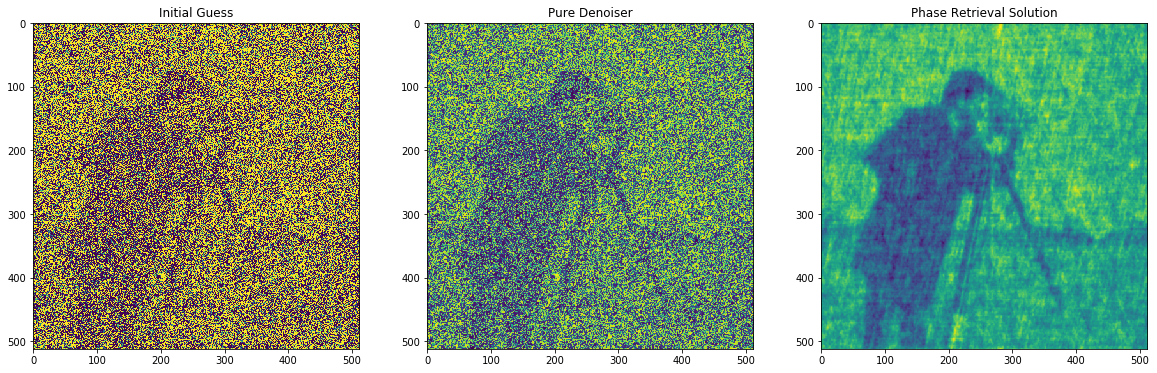

In [5]:

# Construct noisy initial guess
Y0 = random_noise(sk_data.camera(),var=2)
plt.imshow(Y0)
plt.show()

# Run up the solver
solver = fasta(A = Linear_map, f= f, gradf=sub_grad_f, g=g, proxg=proxg, x0=Y0,max_iters=50,
            accelerate=True, # Other options: plain, adapative
            evaluate_objective=False, #evaluate objective function at every step, slows it down
            verbose = True
           )

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,6))
ax1.imshow(Y0)
ax1.set_title('Initial Guess')
ax2.imshow(denoise_tv_chambolle(Y0))
ax2.set_title('Pure Denoiser')
ax3.imshow(solver.solution)
ax3.set_title('Phase Retrieval Solution')
plt.show()